In [1]:
pip install fiona

Note: you may need to restart the kernel to use updated packages.


In [2]:
import geopandas as gpd
import fiona
import matplotlib.pyplot as plt

In [3]:
Primary_school_path = r"E:\GIS_File\Project\Geo-project\1st\Primary School.gdb\Primary School.gdb"
layers = fiona.listlayers(Primary_school_path)
layers

['Primary_school_point', 'Road', 'Ward_boundary', 'River']

In [4]:
# Load the ward boundaries
wards = gpd.read_file(Primary_school_path, layer="Ward_boundary")

In [5]:
wards

,OBJECTID,ward,Shape_Length,Shape_Area,geometry
0,2,2,11296.548871,3.267221e+06,"MULTIPOLYGON (((439455.696 2546030.123, 439505..."
1,3,3,5379.138372,1.546773e+06,"MULTIPOLYGON (((438569.729 2547048.954, 438631..."
2,6,6,5742.463140,1.560153e+06,"MULTIPOLYGON (((441239.026 2544353.223, 441284..."
3,7,1,12117.074992,3.152930e+06,"MULTIPOLYGON (((440755.012 2544291.269, 440737..."
4,8,4,17535.838826,5.241272e+06,"MULTIPOLYGON (((438043.21 2547049.535, 438070...."
5,11,7,11753.263449,3.772498e+06,"MULTIPOLYGON (((435305.278 2549100.494, 435281..."
6,12,9,11611.399671,2.711064e+06,"MULTIPOLYGON (((437210.052 2549836.91, 437230...."
7,14,8,10071.718479,3.624781e+06,"MULTIPOLYGON (((435617.226 2552086.898, 435628..."
8,0,5,10388.332736,2.552459e+06,"MULTIPOLYGON (((436642.165 2548145.584, 436684..."


In [6]:
print(wards.crs)

PROJCS["BUTM",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",90],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


In [7]:
# Combine all ward polygons to get the municipal boundary
municipal_boundary = wards.unary_union

C:\Users\HP\AppData\Local\Temp\ipykernel_1532\773326570.py:2: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  municipal_boundary = wards.unary_union


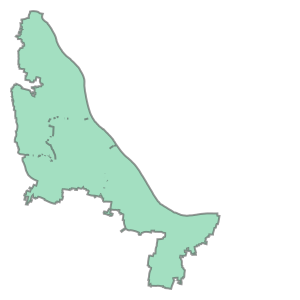

In [8]:
municipal_boundary

In [9]:
# Convert to GeoDataFrame
municipal_boundary = gpd.GeoDataFrame(geometry=[municipal_boundary], crs=wards.crs)

In [10]:
municipal_boundary

,geometry
0,"POLYGON ((441611.903 2542953.353, 441622.994 2..."


In [11]:
Primary_school = gpd.read_file(Primary_school_path, layer='Primary_school_point')

In [12]:
# Step 1: Create 500m buffer around each school
schools_buffer = Primary_school.copy()
schools_buffer['geometry'] = schools_buffer.buffer(500)

In [13]:
schools_buffer.head()

,AREA,PERIMETER,POF_LC_,POF_LC_ID,ID,SL_NO,NAME,TYPE,geometry
0,0.0,0.0,7.0,147.0,146.0,147.0,Ghoper Ghat GPS,Primary School,"POLYGON ((435664.667 2552081.106, 435662.259 2..."
1,0.0,0.0,34.0,174.0,173.0,174.0,Ame Danga RPS,Primary School,"POLYGON ((435953.147 2550753.318, 435950.74 25..."
2,0.0,0.0,54.0,194.0,193.0,194.0,Nowapara Model GPS,Primary School,"POLYGON ((437780.847 2548385.549, 437778.439 2..."
3,0.0,0.0,67.0,207.0,206.0,207.0,North Dhropadi GPS & Adarsho H/S,Primary School,"POLYGON ((435339.997 2548728.416, 435337.59 25..."
4,0.0,0.0,83.0,223.0,222.0,223.0,South Dhopadi GPS,Primary School,"POLYGON ((435961.017 2547191.349, 435958.61 25..."


In [14]:
# Step 2: Clip buffer with municipal boundary to limit the area
buffer_clipped = gpd.overlay(schools_buffer, municipal_boundary, how='intersection')

In [15]:
# Step 3: Union all buffer zones together
all_buffers_union = buffer_clipped.unary_union

C:\Users\HP\AppData\Local\Temp\ipykernel_1532\1536890695.py:2: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  all_buffers_union = buffer_clipped.unary_union


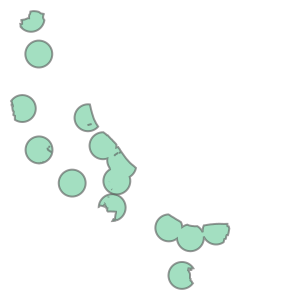

In [16]:
all_buffers_union

In [17]:
# Step 4: Served area = area covered by buffer
served_area = gpd.GeoDataFrame(geometry=[all_buffers_union], crs=municipal_boundary.crs)

In [18]:
from shapely.geometry import Polygon
from shapely.ops import unary_union
import itertools

# Step 5: Overserved area = overlap between different school buffers
overserved_geoms = []

for i, j in itertools.combinations(schools_buffer.geometry, 2):
    inter = i.intersection(j)
    if not inter.is_empty and inter.area > 0:
        overserved_geoms.append(inter)

# Convert to GeoDataFrame
if overserved_geoms:
    overserved_union = unary_union(overserved_geoms)
    overserved_gdf = gpd.GeoDataFrame(geometry=[overserved_union], crs=municipal_boundary.crs)

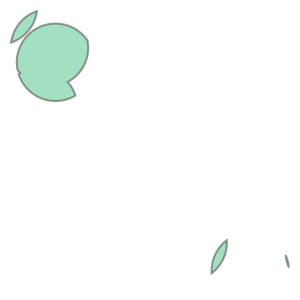

In [19]:
overserved_union

In [20]:
overserved_gdf = gpd.GeoDataFrame(geometry=[overserved_union], crs=municipal_boundary.crs)

In [21]:
# Step 6: Underserved area = total municipal area - buffer area
underserved = gpd.overlay(municipal_boundary, served_area, how='difference')

In [22]:
underserved

,geometry
0,"MULTIPOLYGON (((441622.994 2542920.082, 441576..."


In [23]:
# Step 7: Calculate areas (in square meters → km²)
total_area = municipal_boundary.geometry.area.sum() / 1e6
served_area_km2 = served_area.geometry.area.sum() / 1e6
overserved_area_km2 = overserved_gdf.geometry.area.sum() / 1e6
underserved_area_km2 = underserved.geometry.area.sum() / 1e6

In [24]:
# Step 8: Calculate percentages
served_percent = (served_area_km2 / total_area) * 100
overserved_percent = (overserved_area_km2 / total_area) * 100
underserved_percent = (underserved_area_km2 / total_area) * 100

In [25]:
# Print results
print("Total Area (km²):", round(total_area, 2))
print("Served Area:", round(served_area_km2, 2), "km² (", round(served_percent, 2), "% )")
print("Overserved Area:", round(overserved_area_km2, 2), "km² (", round(overserved_percent, 2), "% )")
print("Underserved Area:", round(underserved_area_km2, 2), "km² (", round(underserved_percent, 2), "% )")

Total Area (km²): 27.43
Served Area: 9.51 km² ( 34.68 % )
Overserved Area: 0.79 km² ( 2.87 % )
Underserved Area: 17.92 km² ( 65.32 % )


C:\Users\HP\AppData\Local\Temp\ipykernel_1532\3514696242.py:6: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


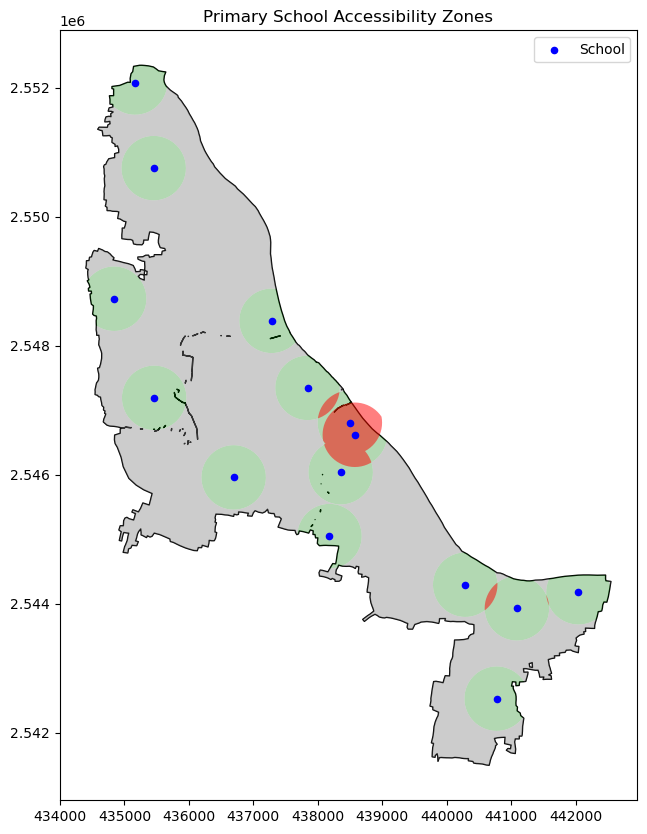

In [26]:
base = municipal_boundary.plot(edgecolor='black', facecolor='none', figsize=(10, 10))
served_area.plot(ax=base, color='green', alpha=0.3, label='Served')
overserved_gdf.plot(ax=base, color='red', alpha=0.5, label='Overserved')
underserved.plot(ax=base, color='gray', alpha=0.4, label='Underserved')
Primary_school.plot(ax=base, color='blue', markersize=20, label='School')
plt.legend()
plt.title("Primary School Accessibility Zones")
plt.show()

In [27]:
import leafmap.foliumap as leafmap

# Initialize the map centered on the municipality
m = leafmap.Map(center=[22.8, 89.55], zoom=14)  # Adjust lat/lon if needed

# Add layers
m.add_gdf(municipal_boundary, layer_name="Municipal_Boundary", style={"fillOpacity": .3, "color": "black"})
m.add_gdf(served_area, layer_name="Served Area", style={"color": "green", "fillOpacity": 0.4})
m.add_gdf(Primary_school, layer_name="Primary Schools", marker_type="circle", marker_kwargs={"radius": 5, "color": "red"})

m

In [28]:
import geopandas as gpd
import leafmap.foliumap as leafmap


In [29]:
# Ensure consistent CRS
wards = wards.to_crs(epsg=4326)
Primary_school = Primary_school.to_crs(epsg=4326)
served_area = served_area.to_crs(epsg=4326)

# Calculate served area % by ward
wards['served_area'] = wards.geometry.intersection(served_area.unary_union).area
wards['served_percent'] = (wards['served_area'] / wards.geometry.area) * 100

# Identify underserved wards (<50% served)
underserved_wards = wards[wards['served_percent'] < 50].copy()

# Proposed school centroids (top 3 most underserved)
underserved_wards_sorted = underserved_wards.sort_values('served_percent')
proposed_points = underserved_wards_sorted.head(3).copy()
proposed_points['geometry'] = proposed_points.centroid

# Initialize interactive map
m = leafmap.Map(center=[22.8, 89.6], zoom=13)
m.add_basemap("CartoDB.Positron")

# Add ward layer colored by served percent
m.add_gdf(
    wards,
    layer_name="Wards by Served %",
    info_mode="on_hover",
    color_column="served_percent",
    cmap="black",
    style={"fillOpacity": 0.6}
)

# Add existing school points
m.add_gdf(Primary_school, layer_name="Existing Schools", icon_data="school", marker_color="blue")

# Add proposed school points (red star markers)
m.add_gdf(
    proposed_points,
    layer_name="Proposed Schools",
    marker_type="star",
    marker_color="red",
    marker_size=15
)


# Show map in notebook (optional)
m

In [30]:
import os

# Make sure folder exists
os.makedirs("HTML", exist_ok=True)


# Save the map
m.save("HTML/Primary_school.html")
